# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
a = os.path.abspath("../")
a = os.path.join(a, "logs")
print(a)

NameError: name 'os' is not defined

In [1]:
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display
import cv2

#imports for display^

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils_ex
from mrcnn import utils

import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "weights.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print('Weight file not present so downloading')
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "/Users/hsnsd/Desktop/segmenter-v1/Dataset/train")
EX_DIR = os.path.join(ROOT_DIR, "/Users/hsnsd/Desktop/segmenter-v1/Dataset")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
#test

from mrcnn.config import Config

class InferenceConfig(Config):
    NAME = "teeth"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1 # BG has 80 classes
    IMAGE_SHAPE = [1991, 1127, 3]
    

inference_config = InferenceConfig()
inference_config.IMAGE_SHAPE = [1024, 1024, 3]
inference_config.IMAGE_MAX_DIM = 1024
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024, 1024, 3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

## Extracter

In [16]:
from mrcnn import teeth_ex

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = teeth_ex.BalloonDataset()
pol = dataset.load_balloon(EX_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 6
Class Count: 2
  0. BG                                                
  1. balloon                                           


In [17]:
print(pol[0][1]) #filename

305.jpeg


In [5]:
def getAnnot(filename, pol):
    result =[]
    for i in range(len(pol)):
        if pol[i][1] == filename:
            for cord in pol[i][0]:
                result.append(list(zip(cord['all_points_y'], cord['all_points_x'])))
    return result



annot = getAnnot('304.jpeg', pol)           
print(annot)
            

[]


[0 1 2 3 4 5 6 7]


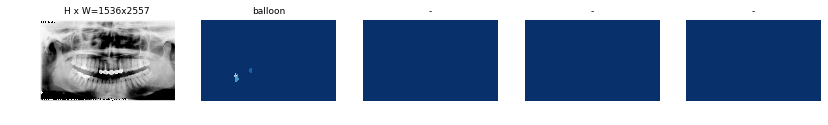

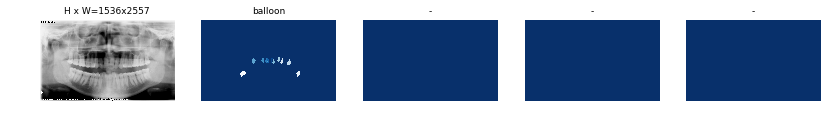

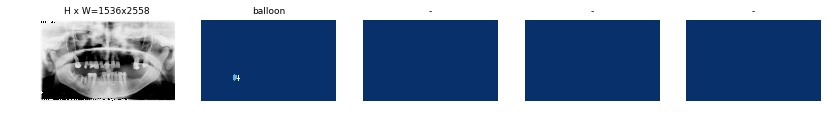

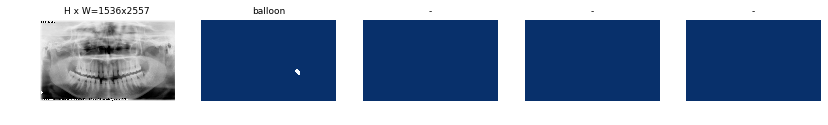

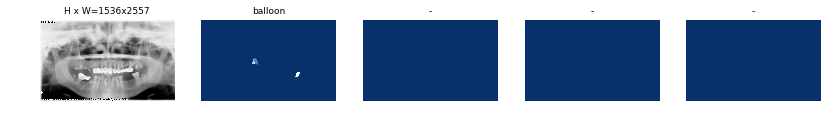

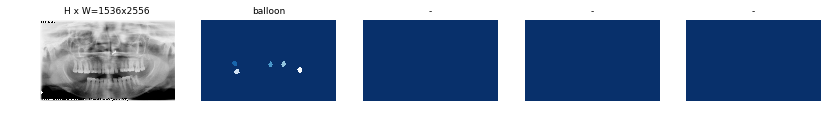

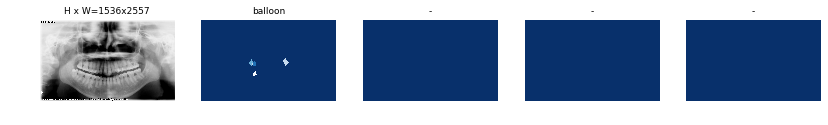

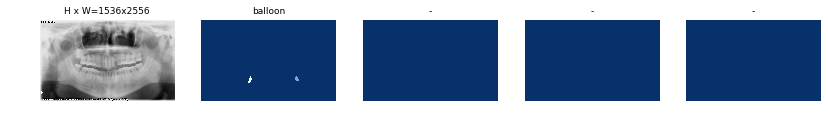

In [172]:
# Load and display random samples
image_ids = dataset.image_ids
print(image_ids)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

    

## Run Object Detection

1536
Processing 1 images
image                    shape: (1536, 2866, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2866.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


Image([[[180, 180, 180],
        [247, 247, 247],
        [248, 248, 248],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]],

       [[101, 101, 101],
        [119, 119, 119],
        [ 91,  91,  91],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]],

       [[149, 149, 149],
        [ 88,  88,  88],
        [ 27,  27,  27],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]],

       ...,

       [[242, 242, 242],
        [247, 247, 247],
        [247, 247, 247],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]],

       [[242, 242, 242],
        [156, 156, 156],
        [161, 161, 161],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [211, 211, 211],
        [211, 211, 211],
        [211, 211, 211]]

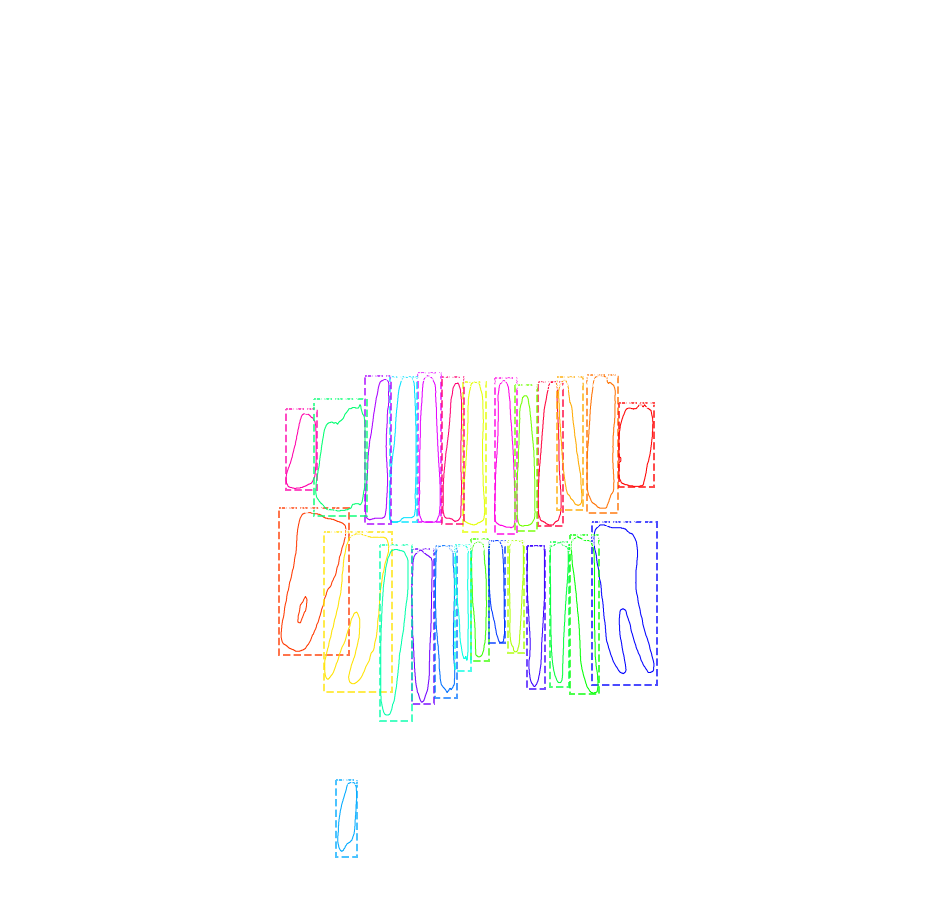

In [19]:
# Load a random image from the images folder
#file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread('/Users/hsnsd/Desktop/segmenter-v1/Mask_RCNN/images/925.jpeg', as_gray=False)
print(len(image))
image = skimage.color.gray2rgb(image)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], r['scores'])

In [174]:
def getCarriedTeeth():
    carryContain = []

    """
    oneCord = []
    print(annot)
    for a in annot:
        oneCord.append(a[0])
    print(oneCord)
    """

    switch = False
    for i in range(len(r['masks'][0][0])):
        switch = False
        for oneCord in annot:
            for cor in oneCord:
                if r['masks'][:,:,i][cor[0]][cor[1]] == True:
                    carryContain.append(i)
                    switch = True
                    break
            if switch == True:
                break

    #print(carryContain)
    return carryContain

In [87]:
carryContain = [2,5]

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

from PIL import Image

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

from random import randint

#Carry detector model. If it returns True, we display the tooth, otherwise not.
def detect(image):
    a = randint(0,9)
    return a<5



def display_instances(carryContain, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):


    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)
    
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height)
    ax.set_xlim(0, width)
    ax.axis('off')
    ax.set_title(title)
    
    
    maxV = 300
    maxH = 200
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        if i not in carryContain:
            continue
        

        mask = masks[:, :, i]
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        

        # Mask
        mask = masks[:, :, i]
        

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    fig = ax.get_figure()
    fig.savefig("output.png")
    ax.imshow(masked_image.astype(np.uint8))
    plt.savefig("a.png", bbox_inches='tight')
    if auto_show:
        plt.show()

    
def checkS():
    background = Image.open("/Users/hsnsd/Desktop/segmenter-v1/Mask_RCNN/samples/925.jpeg")
    overlay = Image.open("/Users/hsnsd/Desktop/segmenter-v1/Mask_RCNN/samples/output.png")
    background = background.convert("RGBA")
    overlay = overlay.convert("RGBA")
    print(background.size)
    print(overlay.size)
    new_img = Image.blend(background, overlay, 1)
    new_img.save("new.png","PNG")


In [85]:
print(image.shape)
print(image.shape[:2] , 'a')
checkS()

(1536, 2866, 3)
(1536, 2866) a
(2866, 1536)
(1152, 1152)


ValueError: images do not match

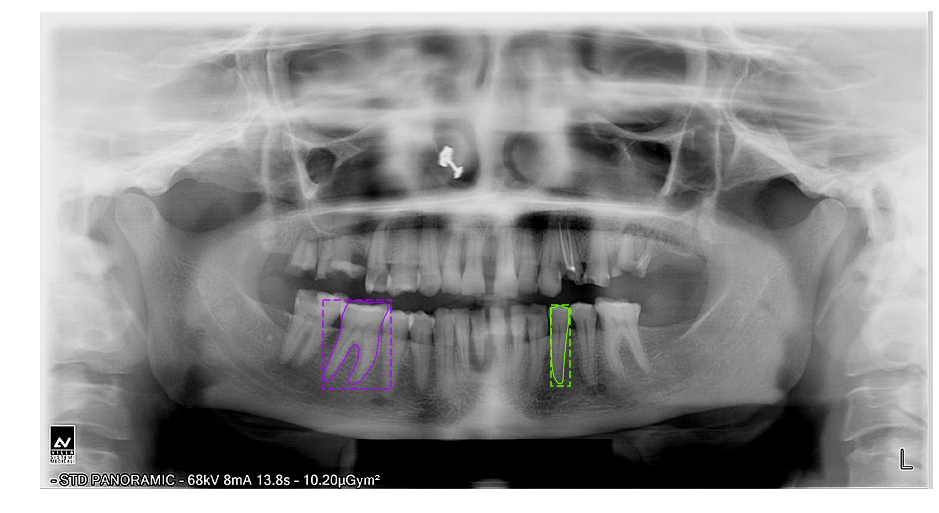

In [88]:
display_instances(carryContain, image, r['rois'], r['masks'], r['class_ids'], r['scores'])

# Save all individual tooth in an array

In [20]:
def save_individuals(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    
    teethSet = []
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

   

    masked_image = image.astype(np.uint32).copy()
    
    #INDIVIDUAL EXTRACTION
    maxV = 0
    maxH = 0
    
    """
    for i in range(N):

        mask = masks[:, :, i]

        y1, x1, y2, x2 = boxes[i]

        if y2-y1 > maxV:
            maxV = y2-y1
        if x2-x1 > maxH:
            maxH = x2-x1
    print(maxV, maxH)
    """
    maxV = 300
    maxH = 250
    for i in range(N):

        mask = masks[:, :, i]

        y1, x1, y2, x2 = boxes[i]

        tmp = image.copy()
        tmp[mask==0] = (0,0,0)

        if y2-y1 != maxV:
            diff = maxV - (y2-y1)
            y2 = y2 + diff//2
            y1 = y1 - diff//2
        if y2-y1 != maxV:
            y2 += 1
            
        if x2-x1 != maxH:
            diff = maxH - (x2-x1)
            x2 = x2 + diff//2
            x1 = x1 - diff//2
            
        if x2-x1 != maxH:
            x2 += 1
            
        tmp = tmp[y1:y2, x1:x2] #SAVE THIS IMAGE IF YOU NEED TO SAVE. THIS REPRESENTS 1 TOOTH
        print(len(tmp), len(tmp[0]), len(tmp[1]), len(tmp[2]))
        print(tmp.shape)
        #UNCOMMENT BELOW LINES TO SAVE EACH TOOTH
        #im = Image.fromarray(tmp)
        #im.save(str(i) + ".jpeg")
        teethSet.append(tmp)
        
    return teethSet
    

In [21]:
teethSet = save_individuals(image, r['rois'], r['masks'], r['class_ids'], r['scores'])

300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
300 250 250 250
(300, 250, 3)
244 250 250 250
(244, 250, 3)
300 250 250 250
(300, 250, 3)


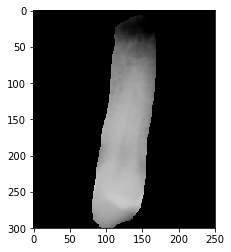

In [130]:
plt.imshow(teethSet[carryContain[2]])
plt.show()


In [155]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err




0.5285867895225923


In [165]:
def getNonCarriedTeeth():
    negSet = []
    for ind in carryContain:
        maxMse = math.inf
        maxIndex = -1

        image = teethSet[ind]
        image_copy = image.copy()
        black_pixels_mask = np.all(image == [0, 0, 0], axis=-1)
        non_black_pixels_mask = np.any(image != [0, 0, 0], axis=-1)  
        # or non_black_pixels_mask = ~black_pixels_mask
        image_copy[black_pixels_mask] = [255, 255, 255]
        image_copy[non_black_pixels_mask] = [0, 0, 0]

        for i in range(len(teethSet)):
            if i in carryContain:
                continue
            teeth = teethSet[i]
            teeth_copy = teeth.copy()
            black_pixels_mask = np.all(teeth == [0, 0, 0], axis=-1)
            non_black_pixels_mask = np.any(teeth != [0, 0, 0], axis=-1)  
            # or non_black_pixels_mask = ~black_pixels_mask
            teeth_copy[black_pixels_mask] = [255, 255, 255]
            teeth_copy[non_black_pixels_mask] = [0, 0, 0]

            score = mse(teeth_copy, image_copy)
            if i not in negSet and score < maxMse:
                maxMse = val
                maxIndex = i
        negSet.append(maxIndex)

        #plt.imshow(teethSet[maxIndex])
        #plt.show()
        return negSet


        
        

In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

from random import randint

#Carry detector model. If it returns True, we display the tooth, otherwise not.
def detect(image):
    a = randint(0,9)
    return a<5

def display_instances(carryContain, image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):


    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)
    
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    
    
    maxV = 300
    maxH = 200
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        if i not in carryContain:
            continue
        

        mask = masks[:, :, i]

        y1, x1, y2, x2 = boxes[i]

        tmp = image.copy()
        tmp[mask==0] = (0,0,0)

        if y2-y1 != maxV:
            diff = maxV - (y2-y1)
            y2 = y2 + diff//2
            y1 = y1 - diff//2
        if x2-x1 != maxV:
            diff = maxV - (x2-x1)
            x2 = x2 + diff//2
            x1 = x1 - diff//2
        tmp = tmp[y1:y2, x1:x2] #SAVE THIS IMAGE IF YOU NEED TO SAVE. THIS REPRESENTS 1 TOOTH
        
        
        #UNCOMMENT BELOW LINES TO SAVE EACH TOOTH
        #im = Image.fromarray(tmp)
        #im.save(str(i) + ".jpeg")
        #plt.imshow(tmp)
        #plt.show()
        

        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
    


In [ ]:
display_instances(carryContain, image, r['rois'], r['masks'], r['class_ids'], r['scores'])